<a href="https://colab.research.google.com/github/deClot/Hakaton_Superhero/blob/master/1_Lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from plotly.offline import init_notebook_mode, iplot


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)
 
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)


In [3]:
df = pd.read_excel('1_train.xlsx')

In [7]:
features_unique = df.columns[df.nunique() == 1].tolist()
features_bin = df.columns[df.nunique() == 2].tolist()
CARDINALITY = 15
features_cat =  df.drop('NaturalPersonID', axis=1).select_dtypes('object').columns.tolist()
features_cat_all = df.nunique()[(df.nunique()<=CARDINALITY)& (df.nunique()>2)]

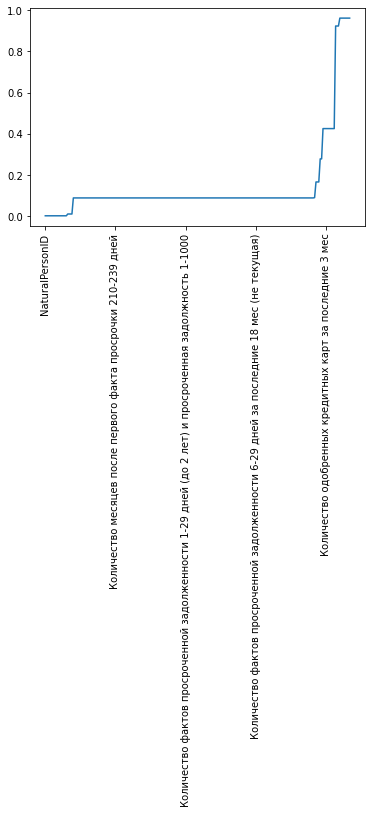

In [ ]:
(df.isna().sum()/df.shape[0]).sort_values().plot(rot=90);


In [10]:
def get_season(x):
  return 1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_season'] = df[t+'_month'].apply(get_season)
        df[t+'_is_month_start'] = df[t].dt.is_month_start
        df[t+'_is_month_end'] = df[t].dt.is_month_end
        df[t+'_day'] = df[t].dt.day
        # df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = df[t+'_dayofweek'] >= 5
        df[t+'_quarter'] = df[t].dt.quarter

In [17]:
preprocess_datetime(df, ['RequestDate'])
df = df.drop('RequestDate', axis=1)
features_time = [f for f in df.columns if 'RequestDate_' in f]
features_time

['RequestDate_month',
 'RequestDate_season',
 'RequestDate_is_month_start',
 'RequestDate_is_month_end',
 'RequestDate_day',
 'RequestDate_dayofweek',
 'RequestDate_is_weekend',
 'RequestDate_quarter']

In [19]:
df.drop(['NaturalPersonID'],axis=1, inplace=True)

In [27]:
df[features_cat] = df[features_cat].astype('category')

In [35]:
df0 = df.copy()
features_num = [f for f in df.columns if f not in features_cat]
df0[features_num] = df0[features_num].fillna(-1)

In [21]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

In [22]:
from lightgbm import LGBMClassifier, cv
import lightgbm as lgb
import matplotlib.gridspec as gridspec

In [291]:
1/6

0.16666666666666666

In [292]:
X, X_test, y, y_test = train_test_split(df0.drop('Target', axis=1), df.Target,
                                        test_size=0.16, 
                                        stratify=df.Target, random_state=2020)

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for train_idx, val_idx in cv5.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    break

In [293]:
from sklearn.metrics import roc_curve

def rounder(y_val, pred):
  fpr,tpr,th = roc_curve(y_val, pred)
  distances = np.sqrt((0-fpr)**2 + (1-tpr)**2)
  idx = distances.argmin()

  return np.where(pred >=0.1, 1, 0)

from sklearn.metrics import f1_score
def rounder(x, th=0.1):
    return 1 if x >= th else 0

def f1(y_hat, data):
    y_true = data.get_label()
    y_hat = pd.Series(y_hat).apply(rounder)
    return 'f1', f1_score(y_true, y_hat), True

0.1679990316895253


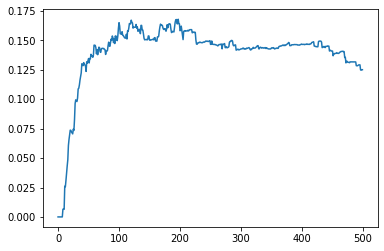

In [294]:
lgb_params = {'objective': 'binary',
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'learning_rate': 0.02,
        'min_child_samples': 10,

        # 'subsample': 0.623,
        # 'colsample_bytree': 0.2,
        'num_leaves': 21,
        # 'max_depth': 3,
        # 'seed': seed,
        # 'bagging_freq': 1,
        'n_jobs': 4
    }

params = {'learning_rate': 0.03,
          'num_leaves': 15,
          'objective': 'binary',
          'min_child_samples': 10,
          'n_jobs': -1,
          'is_unbalance': False}

dtrain = lgb.Dataset(X, y, free_raw_data=False)

res = cv(params, dtrain, num_boost_round=500, folds=cv5, feval=f1,
   categorical_feature=features_cat
   )
# clf = lgb.train(params=lgb_params, train_set=lgb.Dataset(X_train, y_train),
#                 num_boost_round=22, categorical_feature=cat)
print(np.max(res['f1-mean']))
pd.Series(res['f1-mean']).plot();

In [296]:
dtrain = lgb.Dataset(X, y, free_raw_data=False)

In [297]:
clf = lgb.train(params, dtrain, num_boost_round=100)
pred = pd.Series(clf.predict(X_test)).apply(rounder)
f1_score(y_test, pred)

0.14814814814814814

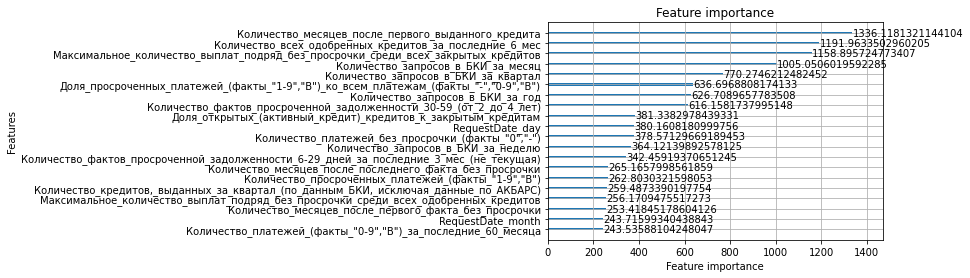

In [298]:
lgb.plot_importance(clf,max_num_features=20, importance_type='gain');

# Null importances

In [299]:
def get_feature_importances(params, X, y, features_cat, shuffle, seed=None):
    train_features = X.columns
    if shuffle:
        # Here you could as well use a binomial distribution
        y = y.sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(X, y, free_raw_data=False, silent=True)
    
    # Fit the model
    clf = lgb.train(params=params, train_set=dtrain, num_boost_round=200, 
                    categorical_feature=features_cat)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = f1(clf.predict(X), dtrain)[1]
    
    return imp_df

In [59]:
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(params, X, y, features_cat, shuffle=False)
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,Количество участников в заявке,16.244630,4,0.769524
1,Количество фактов без просроченной задолженнос...,30.006310,3,0.769524
2,Количество фактов без просроченной задолженнос...,97.524038,9,0.769524
3,Количество фактов без просроченной задолженнос...,126.278591,15,0.769524
4,Количество фактов без просроченной задолженнос...,85.873930,14,0.769524


In [61]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(params, X, y, features_cat, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of   80 (Spent   0.0 min)Done with    2 of   80 (Spent   0.1 min)Done with    3 of   80 (Spent   0.1 min)Done with    4 of   80 (Spent   0.2 min)Done with    5 of   80 (Spent   0.2 min)Done with    6 of   80 (Spent   0.3 min)Done with    7 of   80 (Spent   0.3 min)Done with    8 of   80 (Spent   0.4 min)Done with    9 of   80 (Spent   0.4 min)Done with   10 of   80 (Spent   0.5 min)Done with   11 of   80 (Spent   0.5 min)Done with   12 of   80 (Spent   0.6 min)Done with   13 of   80 (Spent   0.6 min)

In [62]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,Количество участников в заявке,2.985640,1,0.772277,1
1,Количество фактов без просроченной задолженнос...,71.695040,5,0.772277,1
2,Количество фактов без просроченной задолженнос...,54.145440,13,0.772277,1
3,Количество фактов без просроченной задолженнос...,146.650990,15,0.772277,1
4,Количество фактов без просроченной задолженнос...,141.484139,22,0.772277,1


In [67]:
import matplotlib.pyplot as plt
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
    

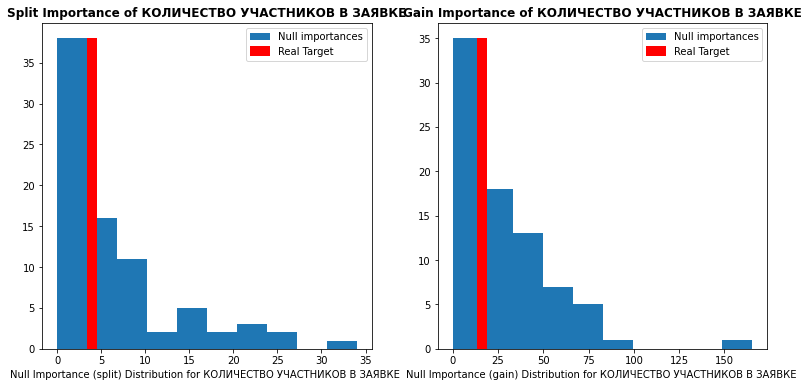

In [68]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='Количество участников в заявке')

In [70]:
import seaborn as sns

Text(0.5, 1.0, 'Feature scores wrt gain importances')

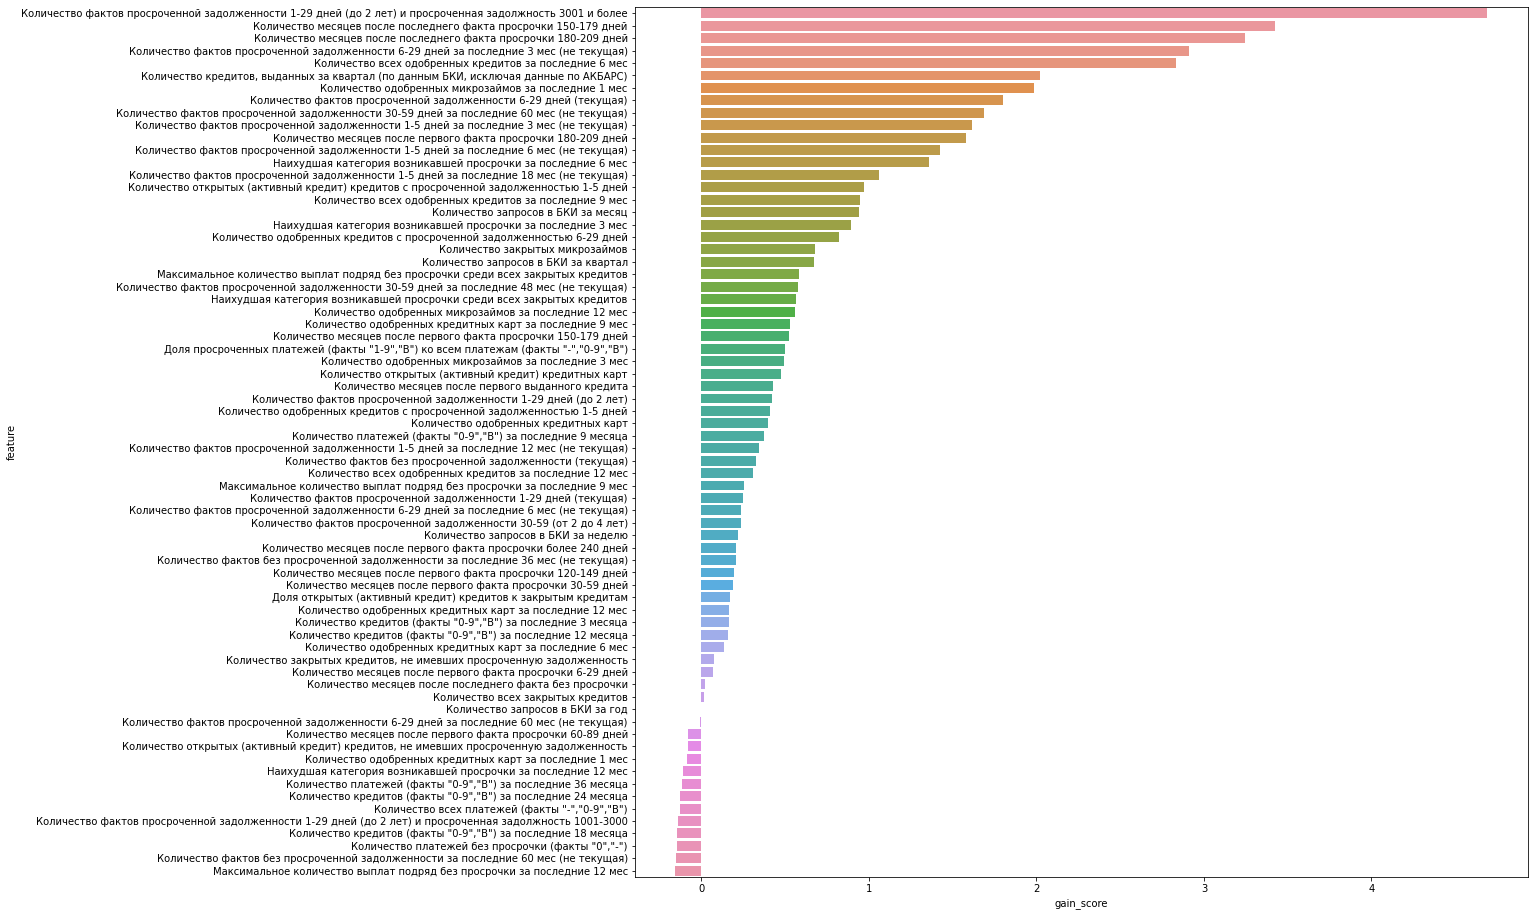

In [74]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
# gs = gridspec.GridSpec(1, 2)
# Plot Split importances
# ax = plt.subplot(gs[0, 0])
# sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
# ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70])
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
# plt.tight_layout()

In [123]:
def plot_results(*data, names=['ini', 'lst']):
    for d, n in zip(data, names):
        d = pd.DataFrame(d)
        plt.plot(d.index.tolist(), d['f1-mean'], label=n)
        plt.fill_between(d.index.tolist(), d['f1-mean']-d['f1-stdv'], d['f1-mean']+d['f1-stdv'], alpha=0.25)
    plt.legend()
    plt.show()

In [276]:
features_null_imp_gain = scores_df[scores_df.gain_score >= 0].sort_values('gain_score').feature
features_null_imp_cat = [f for f in features_cat if f in features_null_imp_gain]

0.21091644335460033


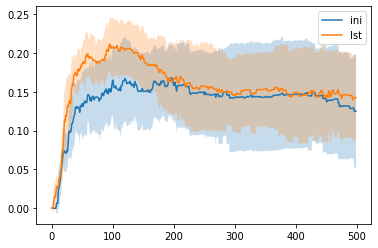

In [313]:
features_null_imp_cat = [f for f in features_cat if f in features_null_imp_gain]
dtrain = lgb.Dataset(X[features_null_imp_gain], y)

params = {'learning_rate': 0.03,
          'num_leaves': 17,
          'min_child_samples': 7,
        # 'subsample': 0.623,
        # 'colsample_bytree': 0.2,
        # 'max_depth': 3,
        # 'seed': seed,
        # 'bagging_freq': 1,
        
          'objective': 'binary',
          'n_jobs': -1,
          'is_unbalance': False}

res_null_imp = cv(params, dtrain, num_boost_round=500, folds=cv5, feval=f1,
  #  categorical_feature=features_null_imp_cat
   )
# clf = lgb.train(params=lgb_params, train_set=lgb.Dataset(X_train, y_train),
#                 num_boost_round=22, categorical_feature=cat)
print(np.max(res_null_imp['f1-mean']))
plot_results(res, res_null_imp)

In [342]:
# dtest = lgb.Dataset(X_test, y_test)
dtrain = lgb.Dataset(X[features_null_imp_gain], y)
clf = lgb.train(params, dtrain, num_boost_round=100)

# score_f1 = {}
# for n in range(1, 500):
#   pred = pd.Series(clf.predict(X_test[features_null_imp_gain], num_iteration=n)).apply(rounder)
#   score_f1[n] = f1_score(y_test, pred)

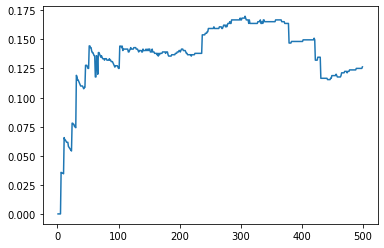

In [345]:
pd.Series(score_f1).plot();